In [1]:
import xgboost as xgb   # model training
from xgboost.sklearn import XGBClassifier
import pickle           # save model
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import metrics   # Additional scklearn functions

import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pylab as plt
%matplotlib inline

ref: https://blog.csdn.net/weiyongle1996/article/details/78360873

In [2]:
%run 101-data_preprocessing.py

In [25]:
def model_fit(model: xgb.XGBClassifier or xgb.XGBRegressor, 
              X: pd.DataFrame or np.array or list, 
              y: pd.DataFrame or np.array or list, 
              useTrainCV=True,
              cv_folds=5,
              early_stopping_rounds=50
              ) -> None:
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=model.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=True
                          )
        model.set_params(n_estimators=cvresult.shape[0])

    # fit the algorithm on the data
    model.fit(X, y, eval_metric='auc')
    
    # predict training set
    dtrain_predictions = model.predict(X)
    dtrain_predprob = model.predict_proba(X)[:,1]
    
    # print model report
    print('*'*10)
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    print('*'*10)
    
    sns.set_style('whitegrid')
    feat_imp = (pd.Series(model.get_booster().get_fscore())
                .sort_values(ascending=False))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return model

## 1 - Confirm the parameters by cross-validation

[0]	train-auc:0.78084+0.00155	test-auc:0.76612+0.00550
[1]	train-auc:0.82251+0.00523	test-auc:0.80235+0.01120
[2]	train-auc:0.83866+0.00800	test-auc:0.81626+0.01371
[3]	train-auc:0.85180+0.00590	test-auc:0.82340+0.01006
[4]	train-auc:0.86345+0.00234	test-auc:0.83257+0.00770
[5]	train-auc:0.86781+0.00192	test-auc:0.83532+0.00755
[6]	train-auc:0.87241+0.00230	test-auc:0.83774+0.00774
[7]	train-auc:0.87813+0.00244	test-auc:0.84339+0.00990
[8]	train-auc:0.88314+0.00367	test-auc:0.84530+0.00854
[9]	train-auc:0.88540+0.00311	test-auc:0.84590+0.00893
[10]	train-auc:0.88814+0.00351	test-auc:0.84740+0.00841
[11]	train-auc:0.89117+0.00323	test-auc:0.84995+0.00803
[12]	train-auc:0.89510+0.00339	test-auc:0.85231+0.00910
[13]	train-auc:0.89851+0.00174	test-auc:0.85324+0.00891
[14]	train-auc:0.90057+0.00220	test-auc:0.85411+0.00775
[15]	train-auc:0.90219+0.00167	test-auc:0.85419+0.00802
[16]	train-auc:0.90536+0.00226	test-auc:0.85640+0.00706
[17]	train-auc:0.90752+0.00169	test-auc:0.85973+0.00768
[1

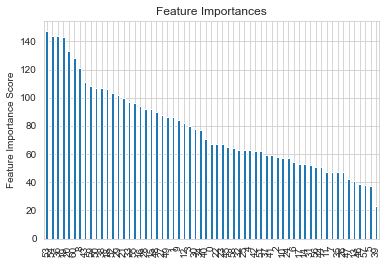

In [4]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=3612)

xgb2 = model_fit(xgb1, X_train, y_train_t1)

In [5]:
print('best n_estimators:', xgb2.get_params()['n_estimators'])
print('best max_depth:', xgb2.get_params()['max_depth'])
print('best min_child_weight:', xgb2.get_params()['min_child_weight'])
print('best gamma:', xgb2.get_params()['gamma'])
print('best subsample:', xgb2.get_params()['subsample'])
print('best colsample_bytree:', xgb2.get_params()['colsample_bytree'])


best n_estimators: 206
best max_depth: 5
best min_child_weight: 1
best gamma: 0
best subsample: 0.8
best colsample_bytree: 0.8


best n_estimators: 206

## 2 - Optimize `max_depth` and `min_child_weight` by grid search

In [7]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=206, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test1, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        cv=5
                        )

gsearch1.fit(X_train, y_train_t1)
gsearch1.cv_results_, gsearch1.best_score_, gsearch1.best_params_

({'mean_fit_time': array([21.54375381, 17.75572281, 16.70170355, 27.38724484, 26.3806232 ,
         31.18923979, 42.79992709, 41.09611487, 37.86725111, 55.64935765,
         51.48024464, 42.92624884]),
  'std_fit_time': array([1.80629793, 0.22041235, 0.98385609, 0.75334951, 1.5719174 ,
         2.37450821, 4.75203599, 0.76880289, 1.40963798, 2.00767407,
         1.49015335, 5.76718017]),
  'mean_score_time': array([0.04323564, 0.04964967, 0.04637671, 0.04769931, 0.05175042,
         0.0479722 , 0.06026716, 0.05915837, 0.05693865, 0.07008395,
         0.06883378, 0.06000071]),
  'std_score_time': array([0.00861984, 0.01023466, 0.00817808, 0.00715574, 0.01505138,
         0.00543124, 0.01123957, 0.00517643, 0.0095449 , 0.01139644,
         0.00677024, 0.00996269]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [8]:
means = gsearch1.cv_results_["mean_test_score"]
stdevs = gsearch1.cv_results_["std_test_score"]
params = gsearch1.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.885375 (0.026502) with: {'max_depth': 3, 'min_child_weight': 1}
0.885706 (0.025720) with: {'max_depth': 3, 'min_child_weight': 3}
0.886973 (0.025134) with: {'max_depth': 3, 'min_child_weight': 5}
0.882652 (0.024810) with: {'max_depth': 5, 'min_child_weight': 1}
0.885374 (0.023043) with: {'max_depth': 5, 'min_child_weight': 3}
0.885774 (0.021522) with: {'max_depth': 5, 'min_child_weight': 5}
0.883344 (0.024111) with: {'max_depth': 7, 'min_child_weight': 1}
0.881474 (0.026213) with: {'max_depth': 7, 'min_child_weight': 3}
0.883752 (0.027805) with: {'max_depth': 7, 'min_child_weight': 5}
0.886674 (0.024200) with: {'max_depth': 9, 'min_child_weight': 1}
0.885039 (0.025102) with: {'max_depth': 9, 'min_child_weight': 3}
0.885309 (0.023814) with: {'max_depth': 9, 'min_child_weight': 5}


In [13]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=206,
                                                  max_depth=3,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test2, 
                        scoring='roc_auc', 
                        n_jobs=4,
                        cv=5
                        )

gsearch2.fit(X_train,y_train_t1)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_


({'mean_fit_time': array([26.77178822, 15.06864195, 12.33711028, 14.68378716, 14.3601088 ,
         14.25637589, 19.0988102 , 18.33155799, 15.30543203]),
  'std_fit_time': array([5.28471344, 1.13310817, 0.97606586, 0.54223514, 0.15489452,
         0.1796504 , 0.47489462, 0.10268397, 3.44874775]),
  'mean_score_time': array([0.04910254, 0.05024252, 0.04729438, 0.03384113, 0.03881164,
         0.04172091, 0.03619037, 0.03736248, 0.03639255]),
  'std_score_time': array([0.00790009, 0.00960452, 0.01538166, 0.00428694, 0.00889688,
         0.00918561, 0.00450153, 0.00487513, 0.01284608]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [14]:
means = gsearch2.cv_results_["mean_test_score"]
stdevs = gsearch2.cv_results_["std_test_score"]
params = gsearch2.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.882165 (0.028719) with: {'max_depth': 2, 'min_child_weight': 4}
0.883580 (0.026944) with: {'max_depth': 2, 'min_child_weight': 5}
0.882511 (0.027283) with: {'max_depth': 2, 'min_child_weight': 6}
0.887210 (0.023756) with: {'max_depth': 3, 'min_child_weight': 4}
0.886973 (0.025134) with: {'max_depth': 3, 'min_child_weight': 5}
0.885329 (0.023495) with: {'max_depth': 3, 'min_child_weight': 6}
0.887444 (0.023719) with: {'max_depth': 4, 'min_child_weight': 4}
0.887002 (0.025506) with: {'max_depth': 4, 'min_child_weight': 5}
0.887324 (0.023157) with: {'max_depth': 4, 'min_child_weight': 6}


0.8874441517836618

---

'max_depth': 4, 'min_child_weight': 4

## 3 - Optimize `gamma` by grid search

In [15]:
param_test3 = {
 'gamma': [i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=206, max_depth=4, min_child_weight=4, 
                                                  gamma=0, 
                                                  subsample=0.8,
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test3, 
                        scoring='roc_auc', 
                        n_jobs=4,
                        cv=5
                        )

gsearch3.fit(X_train, y_train_t1)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([43.7820816 , 30.02434101, 27.04867191, 26.974998  , 18.61193428]),
  'std_fit_time': array([3.84145614, 7.34021571, 4.71520068, 2.06388793, 6.59225265]),
  'mean_score_time': array([0.05526762, 0.04773517, 0.04484653, 0.05643191, 0.0345027 ]),
  'std_score_time': array([0.00665518, 0.01237572, 0.00449826, 0.00784015, 0.00637696]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.90951571, 0.90951571, 0.90859218, 0.90859218, 0.90747686]),
  'split1_test_score': array([0.90691723, 0.90608829, 0.90446457, 0.9058203 , 0.90600422]),
  'split2_test_score': array([0.89916121, 0.89916121, 0.89916121, 0.89810632, 0.89631839]),
  'split3_test_score': array([0.8747949 , 0.8771648 , 0.87655656, 0.8744113 , 0.881204

In [16]:
means = gsearch3.cv_results_["mean_test_score"]
stdevs = gsearch3.cv_results_["std_test_score"]
params = gsearch3.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.887444 (0.023719) with: {'gamma': 0.0}
0.888663 (0.021775) with: {'gamma': 0.1}
0.888032 (0.021407) with: {'gamma': 0.2}
0.886736 (0.023333) with: {'gamma': 0.3}
0.887474 (0.022586) with: {'gamma': 0.4}


0.8886627299777331

---

'gamma': 0.1

## 4 - Optimize `subsample` and `colsample_bytree` by grid search

In [17]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=206, max_depth=5, min_child_weight=4, gamma=0.1, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch4.fit(X_train, y_train_t1)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([30.97033105, 31.54633574, 34.10649824, 29.01731782, 25.85151715,
         22.86888466, 25.37151594, 22.83478789, 23.71156769, 24.39170747,
         25.01015797, 27.82046394, 26.6707612 , 26.88808193, 30.89348245,
         28.21591063]),
  'std_fit_time': array([1.5779341 , 4.05941043, 2.60876989, 1.30684136, 3.45513317,
         4.5634338 , 2.77572425, 0.22809634, 0.31763323, 0.16760143,
         0.62528087, 0.63570551, 0.23687854, 0.38504295, 2.76536652,
         2.45517561]),
  'mean_score_time': array([0.05256515, 0.04639702, 0.03774071, 0.05229282, 0.0470068 ,
         0.04229708, 0.04293838, 0.03615651, 0.04966383, 0.04096794,
         0.04331784, 0.04189634, 0.04729276, 0.04388685, 0.04700699,
         0.04286714]),
  'std_score_time': array([0.004281  , 0.01355591, 0.00410205, 0.01477974, 0.00841864,
         0.00509428, 0.00492526, 0.00395564, 0.00759673, 0.00759457,
         0.00858609, 0.0042195 , 0.00275993, 0.00438163, 0.00808481,
         0.007569

In [18]:
param_test4a = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch4a = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=206, max_depth=5, min_child_weight=4, gamma=0.1, 
                                                  subsample=0.8, colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test4a, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch4a.fit(X_train, y_train_t1)
gsearch4a.cv_results_, gsearch4a.best_params_, gsearch4a.best_score_

({'mean_fit_time': array([39.20391521, 33.41648283, 26.11753659, 25.04632878, 24.08108945,
         24.9261744 , 25.75457082, 25.965172  , 21.70362282]),
  'std_fit_time': array([1.82460973, 2.17126996, 3.94292946, 0.91185144, 0.08517334,
         0.37520248, 0.21657738, 0.0637767 , 7.23561186]),
  'mean_score_time': array([0.09693675, 0.05097852, 0.04544721, 0.03648648, 0.03915138,
         0.04528513, 0.04495153, 0.04107866, 0.04437361]),
  'std_score_time': array([0.04326015, 0.01892811, 0.00699028, 0.00405924, 0.00630959,
         0.00767658, 0.00595691, 0.00540895, 0.01095415]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, Fa

In [19]:
means = gsearch4.cv_results_["mean_test_score"]
stdevs = gsearch4.cv_results_["std_test_score"]
params = gsearch4.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.887036 (0.020597) with: {'colsample_bytree': 0.6, 'subsample': 0.6}
0.887364 (0.023191) with: {'colsample_bytree': 0.6, 'subsample': 0.7}
0.886095 (0.023752) with: {'colsample_bytree': 0.6, 'subsample': 0.8}
0.884713 (0.023324) with: {'colsample_bytree': 0.6, 'subsample': 0.9}
0.887026 (0.024331) with: {'colsample_bytree': 0.7, 'subsample': 0.6}
0.884030 (0.024476) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.887221 (0.023241) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.883413 (0.024440) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.884995 (0.022759) with: {'colsample_bytree': 0.8, 'subsample': 0.6}
0.884562 (0.022554) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.887616 (0.021830) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.885689 (0.024362) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.882294 (0.023758) with: {'colsample_bytree': 0.9, 'subsample': 0.6}
0.886808 (0.021063) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.884879 (0.026104) 

0.8876157196061559

---

'colsample_bytree': 0.8, 'subsample': 0.8

## 5 - Optimize `reg_alpha` and `reg_lambda` by grid search

In [20]:
param_test5 = {
 'reg_alpha':[0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.5],
 'reg_lambda':[0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.5]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=206, max_depth=5, min_child_weight=4, gamma=0.1, 
                                                  subsample=0.8, colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch5.fit(X_train, y_train_t1)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([ 37.2647038 ,  27.15126481,  24.88328257,  25.63707399,
          28.81260509,  32.42880163,  27.72280936,  25.80410347,
          24.39483638,  25.201018  ,  24.54054337,  24.83209028,
         210.28238511, 644.85915565,  72.85904064,  37.42606001,
          26.97409539,  30.57111897,  37.29482017,  45.415767  ,
          25.67963223,  23.13369999,  20.23037572,  18.30187783,
          18.98753395,  22.54018335,  25.64726858,  25.20386052,
          22.88735976,  22.48117456,  24.53070354,  26.80729213,
          23.6374064 ,  24.48434629,  21.00164905,  24.13833852,
          20.85482912,  20.378407  ,  18.61038275,  17.26463828,
          19.72945991,  19.06603065,  20.36261559,  22.21952009,
          22.44172144,  23.73330321,  23.39653182,  20.04961061,
          13.6188159 ]),
  'std_fit_time': array([4.05296935e+00, 2.55064223e+00, 7.50787691e-01, 1.02725828e-01,
         2.01666359e+00, 6.47775551e-01, 3.32362254e+00, 5.55093728e-01,
         1.82836

In [28]:
param_test5a = {
 'reg_alpha':[0.6, 0.65, 0.7, 0.75, 0.8],
 'reg_lambda':[0.04, 0.05, 0.06]
}

gsearch5a = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=206, max_depth=5, min_child_weight=4, gamma=0.1, 
                                                  subsample=0.8,
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test5a, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch5a.fit(X_train, y_train_t1)
gsearch5a.cv_results_, gsearch5a.best_params_, gsearch5a.best_score_

({'mean_fit_time': array([20.16897311, 19.44836998, 18.65676193, 19.19491096, 18.84611907,
         18.69850092, 19.15250974, 18.88004308, 18.87753348, 19.23780661,
         21.69101911, 68.16638045, 34.14093885, 18.6723484 , 16.20291076]),
  'std_fit_time': array([ 0.173115  ,  0.59578363,  0.19261195,  0.28202295,  0.22962322,
          0.40043024,  0.217319  ,  0.08082242,  0.08220637,  0.31642328,
          1.5421954 , 22.55313756,  8.4627525 ,  1.08099849,  3.26846559]),
  'mean_score_time': array([0.03922257, 0.03727784, 0.03985782, 0.03625836, 0.03433766,
         0.03763394, 0.03910565, 0.0370657 , 0.03693562, 0.03762889,
         0.03496475, 0.07457633, 0.03282824, 0.03474545, 0.03230038]),
  'std_score_time': array([0.00343592, 0.00433611, 0.00826869, 0.00432822, 0.00367896,
         0.00717601, 0.0071781 , 0.00368678, 0.00505118, 0.01129645,
         0.00527134, 0.03037464, 0.0021788 , 0.00574926, 0.0092511 ]),
  'param_reg_alpha': masked_array(data=[0.6, 0.6, 0.6, 0.65, 0.6

In [ ]:
param_test5b = {
 'reg_alpha':[0.6, 0.65, 0.7, 0.75, 0.8]
}

gsearch5b = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=206, max_depth=5, min_child_weight=4, gamma=0.1, 
                                                  subsample=0.8,
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  reg_lambda=0.04,
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test5b, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch5b.fit(X_train, y_train_t1)
gsearch5b.cv_results_, gsearch5b.best_params_, gsearch5b.best_score_

In [65]:
means = gsearch5a.cv_results_["mean_test_score"]
stdevs = gsearch5a.cv_results_["std_test_score"]
params = gsearch5a.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.885601 (0.022820) with: {'reg_alpha': 0, 'reg_lambda': 0}
0.885601 (0.022820) with: {'reg_alpha': 0, 'reg_lambda': 1e-05}
0.884640 (0.024087) with: {'reg_alpha': 0, 'reg_lambda': 0.01}
0.884756 (0.024939) with: {'reg_alpha': 0, 'reg_lambda': 0.05}
0.885360 (0.024449) with: {'reg_alpha': 0, 'reg_lambda': 0.07}
0.884262 (0.021843) with: {'reg_alpha': 0, 'reg_lambda': 0.1}
0.885513 (0.023613) with: {'reg_alpha': 0, 'reg_lambda': 0.5}
0.885601 (0.022820) with: {'reg_alpha': 1e-05, 'reg_lambda': 0}
0.885601 (0.022820) with: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
0.884639 (0.024086) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
0.884756 (0.024940) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.05}
0.885360 (0.024449) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.07}
0.884262 (0.021843) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
0.885514 (0.023613) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.5}
0.882848 (0.025888) with: {'reg_alpha': 0.01, 'reg_lambda': 0}
0.882848 (0.025888) with: {'reg_alp

0.8875269142095202

---

'reg_alpha': 0.65, 'reg_lambda': 0.04

## 6 - Optimize `learning_rate` by grid search

In [67]:
param_test6 = {
    'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=206, max_depth=5, min_child_weight=4, gamma=0.1, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  reg_alpha=0.65,
                                                  reg_lambda=0.04,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test6,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch6.fit(X_train, y_train_t1)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_
    

({'mean_fit_time': array([20.03313484, 21.70004444, 22.7684762 , 17.71909618, 19.24036803,
         17.70582881, 17.73078537, 17.91299162, 19.79024134, 22.160356  ,
         26.49286838, 23.63582978, 22.61446104, 19.5823875 ]),
  'std_fit_time': array([0.71911227, 4.02995451, 2.51476054, 1.03602891, 1.14234307,
         0.87114169, 0.92881146, 0.44477424, 0.64611598, 1.26771501,
         2.55494481, 2.45449716, 0.77672965, 5.64768943]),
  'mean_score_time': array([0.04575157, 0.03660989, 0.04617286, 0.03571906, 0.03615537,
         0.04047379, 0.04189501, 0.04555578, 0.04779286, 0.04392033,
         0.04387369, 0.04708161, 0.04271226, 0.04877357]),
  'std_score_time': array([0.01096698, 0.00264816, 0.0101064 , 0.00330296, 0.00944332,
         0.00806712, 0.00455348, 0.0096834 , 0.00951181, 0.00583704,
         0.00387473, 0.01247788, 0.00604612, 0.01534514]),
  'param_learning_rate': masked_array(data=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                     0.1, 0.2,

In [71]:
param_test6a = {
    'learning_rate':[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
}

gsearch6a = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=206, max_depth=5, min_child_weight=4, gamma=0.1, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  reg_alpha=0.01,
                                                  reg_lambda=0.05,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test6a,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch6a.fit(X_train, y_train_t1)
gsearch6a.cv_results_, gsearch6a.best_params_, gsearch6a.best_score_
    

({'mean_fit_time': array([57.96102877, 80.96179299, 69.64684339, 80.64561243, 82.57514133,
         92.6414865 , 80.89990649]),
  'std_fit_time': array([16.27093425, 11.65346351,  2.41585162,  4.46475781,  3.76278769,
          0.86315386,  9.50309846]),
  'mean_score_time': array([0.1041472 , 0.1916234 , 0.09364195, 0.19773788, 0.15645809,
         0.240834  , 0.22380733]),
  'std_score_time': array([0.05794902, 0.13485561, 0.05596717, 0.13097552, 0.23123854,
         0.09710723, 0.12829727]),
  'param_learning_rate': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.4},
   {'learning_rate': 0.45},
   {'learning_rate': 0.5},
   {'learning_rate': 0.55},
   {'learning_rate': 0.6},
   {'learning_rate': 0.65},
   {'learning_rate': 0.7}],
  'split0_test_score': array([0.87361521, 0.87100359, 0.87594701, 0.87052016, 0.87018254,

In [72]:
means = gsearch6a.cv_results_["mean_test_score"]
stdevs = gsearch6a.cv_results_["std_test_score"]
params = gsearch6a.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.846421 (0.032552) with: {'learning_rate': 0.4}
0.847502 (0.026140) with: {'learning_rate': 0.45}
0.849605 (0.028584) with: {'learning_rate': 0.5}
0.846822 (0.023919) with: {'learning_rate': 0.55}
0.835705 (0.034878) with: {'learning_rate': 0.6}
0.834812 (0.036543) with: {'learning_rate': 0.65}
0.836551 (0.029158) with: {'learning_rate': 0.7}


In [ ]:
# 